## How to split the data

Load the data and packages and standaridize the text

come up with clever features
part of speech tagger
avg word length
length of description

try naive bayes. it doesn't have cross terms, only works for linear situations. generative model (class -> prevalence)

In [1]:
%matplotlib inline
import pandas as pd
import re
import codecs

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')

from functools import reduce

def neatify_headers(df):
    old_col_headers = list(df)
    new_col_headers = [och.replace(' ', '') for och in old_col_headers]
    rename_headers_map = {och: nch for och, nch in zip(old_col_headers, new_col_headers)}
    return df.rename(columns=rename_headers_map)

# 'preschool_prek', 
filenames = ('k_2', '3_5', '6_8', '9_12')
dfs = []
for grade_category, filename in enumerate(filenames):
    df = pd.read_csv("cal_dept_of_edu/{}.csv".format(filename))
    df = neatify_headers(df)
    df['GradeCategory'] = grade_category
    dfs.append(df)
df = reduce(lambda a, b: a.append(b), dfs)

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

standardize_text(df, "Annotation")

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df["tokens"] = df["Annotation"].apply(tokenizer.tokenize)

import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html
df['no_punctuation_tokens'] = df['tokens'].apply(lambda tkns: [regex.sub(u'', tkn) for tkn in tkns])

from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))
df['no_stop_tokens'] = df['no_punctuation_tokens'].apply(lambda tkns: list(filter(lambda tkn: tkn not in stopword_set, tkns)))


from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()
df['lemmatized_tokens'] = df['no_stop_tokens'].apply(lambda tkns: [wordnet.lemmatize(tkn) for tkn in tkns])

df['standarized_annotation'] = df['lemmatized_tokens'].apply(" ".join)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skunche/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/skunche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/skunche/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Text(0,0.5,'Number of Books')

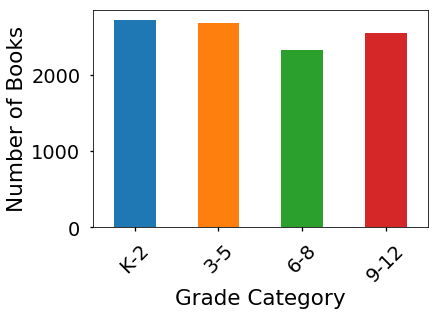

In [2]:
import seaborn as sns
sns.set_context("talk", font_scale=1.5)
ax = df.groupby(['GradeCategory']).count()['TitleID'].plot.bar()
ax.set_xticklabels(['K-2','3-5', '6-8', '9-12'], rotation=45)
ax.set_xlabel('Grade Category')
ax.set_ylabel('Number of Books')

/anaconda3/envs/insight/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


345608 words total, with a vocabulary size of 20615
Max sentence length is 99


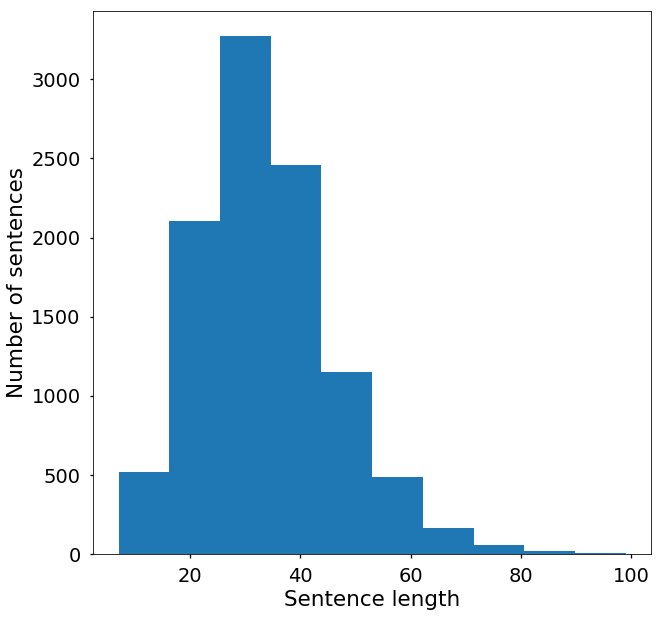

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["lemmatized_tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["lemmatized_tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

First, let's get started with an initial 20/80 training/testing split and tune the C hyperparameter for logistic regression.

Set random state to make the outputs repeatable.
Narrow the gridsearch domain iteratively.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

list_corpus = df["standarized_annotation"].tolist()
list_labels = df["GradeCategory"].tolist()

# Max and min thresholds for tfidf. Maybe remove words that are only specific to a single book
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

tfidfs, tfidf_vectorizer = tfidf(list_corpus)

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidfs, list_labels, test_size=0.2, random_state=777)

In [10]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=777)

In [11]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
classifier = LogisticRegressionCV(class_weight='balanced', 
                                  solver='newton-cg', 
                                  multi_class='multinomial', 
                                  n_jobs=-1,
                                  random_state=40)
classifier.fit(X_train, y_train)
print(classifier.C_, classifier.scores_[1].mean(axis=0).max())

[0.04641589 0.04641589 0.04641589 0.04641589] 0.5362955003504392


In [12]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
classifier = LogisticRegressionCV(class_weight='balanced', 
                                  solver='newton-cg', 
                                  multi_class='multinomial', 
                                  n_jobs=-1,
                                  Cs=np.linspace(0.3341, 0.33411, 10),
                                  random_state=40
                                 )
classifier.fit(X_train, y_train)
print(classifier.C_, classifier.scores_[1].mean(axis=0).max())

[0.3341 0.3341 0.3341 0.3341] 0.5364156359610454


In [13]:
from sklearn.model_selection import GridSearchCV
import numpy as np
grid = {
    'C': np.linspace(0.3341, 0.33411, 10)
}
classifier = GridSearchCV(estimator=estimator, param_grid=grid)
classifier.fit(X_train, y_train)
print(classifier.best_estimator_.C, classifier.best_score_)

0.3341 0.5359277784555325


In [ ]:
classifier.cv_results_

Both `GridSearchCV` and `LogisticRegressionCV` give the same estimate for `C` with similar best scores.

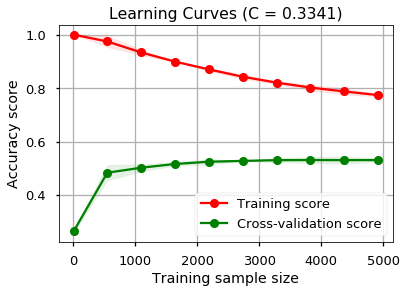

In [18]:
from sklearn.learning_curve import learning_curve
title = 'Learning Curves (C = {0:.4f})'.format(classifier.best_estimator_.C)
estimator = LogisticRegression(class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, C=classifier.best_estimator_.C, random_state=777)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training sample size")
    plt.ylabel("Accuracy score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - (2*train_scores_std),
                     train_scores_mean + (2*train_scores_std), alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - (2*test_scores_std),
                     test_scores_mean + (2*test_scores_std), alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
sns.set_context("talk", font_scale=1.0)
plot_learning_curve(estimator, title, X_train, y_train, train_sizes=[0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.show()

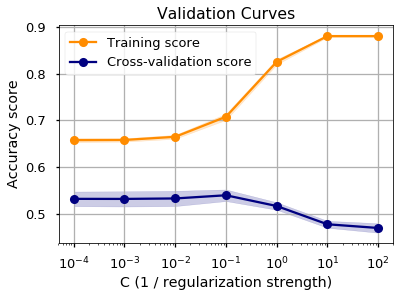

In [19]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, param_range=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("C (1 / regularization strength)")
    plt.ylabel("Accuracy score")
    train_scores, test_scores = validation_curve(
        estimator, X, y, "C", cv=cv, n_jobs=n_jobs, param_range=param_range, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score",
                 color="darkorange")
    plt.fill_between(param_range, train_scores_mean - (2*train_scores_std),
                 train_scores_mean + (2*train_scores_std), alpha=0.2,
                 color="darkorange")
    plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
                 color="navy")
    plt.fill_between(param_range, test_scores_mean - (2*test_scores_std),
                 test_scores_mean + (2*test_scores_std), alpha=0.2,
                 color="navy")

    plt.legend(loc="best")
    return plt

sns.set_context("talk", font_scale=1.0)
plot_validation_curve(estimator, "Validation Curves", X=X_train, y=y_train, param_range=np.logspace(-4, 2, 7))
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

list_labels = df["GradeCategory"].tolist()
y = label_binarize(list_labels, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

tfidfs, tfidf_vectorizer = tfidf(list_corpus)

X_train, X_test, y_train, y_test = train_test_split(tfidfs, y, test_size=0.2, random_state=40, stratify=list_labels)

ovr_clf_tfidf = OneVsRestClassifier(LogisticRegression(C=0.1, class_weight='balanced', solver='newton-cg', 
                                                       multi_class='multinomial', n_jobs=-1, random_state=40))

y_score = ovr_clf_tfidf.fit(X_train, y_train).decision_function(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
category = 3
plt.plot(fpr[category], tpr[category], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[category])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from scipy import interp
from itertools import cycle

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

sns.set_context("poster", font_scale=0.5)
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()